## Overview

In the experiment, I explore unsupervisied learning method usage in structure dataset as a classisifer featrue extractor.


## Setup
Import necessary libraries.

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load the titanic dataset
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

I will use the dataset with the goal of predicting passenger survival, given characteristics such as gender, age, class, etc.

In [2]:
# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')

## Explore the data

View dataset with ```head``` and ```info``` functions. There are 627 and 264 examples in the training and evaluation sets, respectively.

In [94]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,35.0,0,0,8.0500,0,0,0,1
1,0,54.0,0,0,51.8625,1,7,0,1
2,1,58.0,0,0,26.5500,1,1,0,1
3,1,55.0,0,0,16.0000,2,0,0,1
4,0,34.0,0,0,13.0000,2,5,0,1


In [4]:
dfeval.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,35.0,0,0,8.0500,Third,unknown,Southampton,y
1,0,male,54.0,0,0,51.8625,First,E,Southampton,y
2,1,female,58.0,0,0,26.5500,First,C,Southampton,y
3,1,female,55.0,0,0,16.0000,Second,unknown,Southampton,y
4,1,male,34.0,0,0,13.0000,Second,D,Southampton,y


In [5]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   survived            627 non-null    int64  
 1   sex                 627 non-null    object 
 2   age                 627 non-null    float64
 3   n_siblings_spouses  627 non-null    int64  
 4   parch               627 non-null    int64  
 5   fare                627 non-null    float64
 6   class               627 non-null    object 
 7   deck                627 non-null    object 
 8   embark_town         627 non-null    object 
 9   alone               627 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 49.1+ KB


In [6]:
dfeval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   survived            264 non-null    int64  
 1   sex                 264 non-null    object 
 2   age                 264 non-null    float64
 3   n_siblings_spouses  264 non-null    int64  
 4   parch               264 non-null    int64  
 5   fare                264 non-null    float64
 6   class               264 non-null    object 
 7   deck                264 non-null    object 
 8   embark_town         264 non-null    object 
 9   alone               264 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 20.8+ KB


View passengers ages via bar chart, the majority of passengers are in 20's and 30's.

<Axes: >

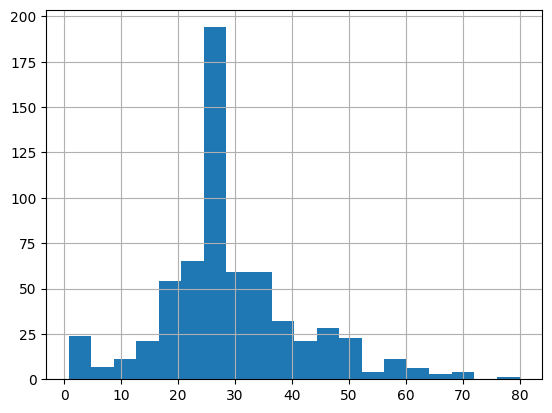

In [7]:
dftrain.age.hist(bins=20)

There are approximately twice as many male passengers as female passengers aboard.

<Axes: >

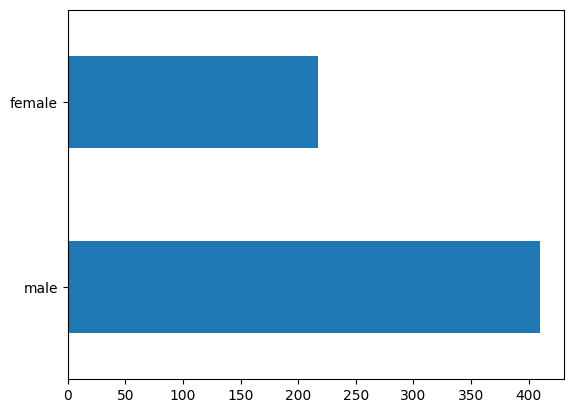

In [8]:
dftrain.sex.value_counts().plot(kind='barh')

Females have a much higher chance of surviving versus males. This is clearly a predictive feature for the model.

Text(0.5, 0, '% survive')

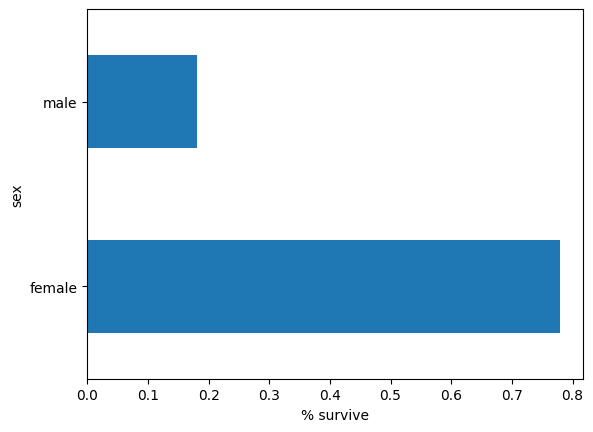

In [10]:
dftrain.groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

View passengers in three classes, the majority of passengers were in the "third" class.

<Axes: >

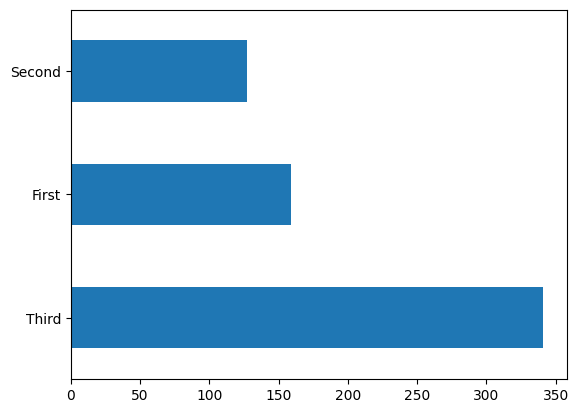

In [9]:
dftrain['class'].value_counts().plot(kind='barh')

## EDA
In the process, in order to fit the model, I transfer string columns to int values.

In [12]:
alone_map = {}
for id, alone in enumerate(dftrain['alone'].unique()):
  alone_map[alone] = id

class_map = {}
for id, clazz in enumerate(dftrain['class'].unique()):
  class_map[clazz] = id

sex_map = {}
for id, sex in enumerate(dftrain['sex'].unique()):
  sex_map[sex] = id

town_map = {}
for id, town in enumerate(dftrain['embark_town'].unique()):
  town_map[town] = id

deck_map = {}
for id, deck in enumerate(dftrain['deck'].unique()):
  deck_map[deck] = id

def convert_numeric(x):
  x['alone'] = alone_map[x['alone']]
  x['class'] = class_map[x['class']]
  x['sex'] = sex_map[x['sex']]
  x['embark_town'] = town_map[x['embark_town']]
  x['deck'] = deck_map[x['deck']]
  return x
dftrain = dftrain.apply(convert_numeric, axis=1)
dfeval = dfeval.apply(convert_numeric, axis=1)

View transfered dataset again.

In [95]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,22.0,1,0,7.2500,0,0,0,0
1,1,38.0,1,0,71.2833,1,1,1,0
2,1,26.0,0,0,7.9250,0,0,0,1
3,1,35.0,1,0,53.1000,1,1,0,0
4,0,28.0,0,0,8.4583,0,0,2,1


In [96]:
dfeval.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,35.0,0,0,8.0500,0,0,0,1
1,0,54.0,0,0,51.8625,1,7,0,1
2,1,58.0,0,0,26.5500,1,1,0,1
3,1,55.0,0,0,16.0000,2,0,0,1
4,0,34.0,0,0,13.0000,2,5,0,1


Draw heatmap to view  columns correlation matrix.

<Axes: >

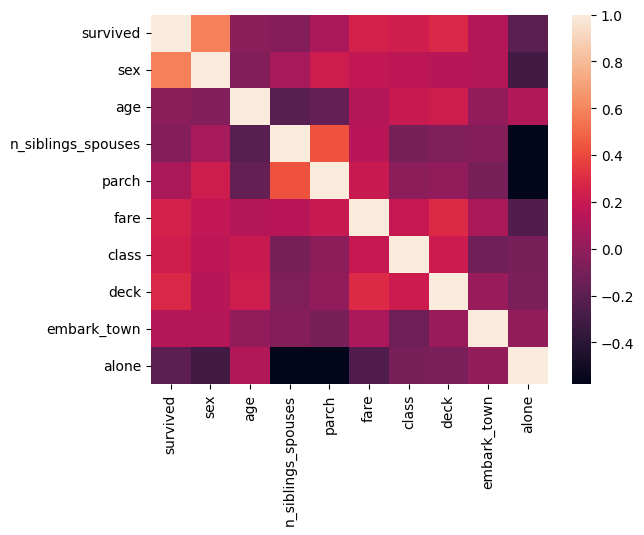

In [14]:
sns.heatmap(dftrain.corr())

Separate labels for training and testing.

In [15]:
label_train = dftrain.pop('survived')
label_eval = dfeval.pop('survived')

## Build base model
The model uses ```StandardScaler``` to scale inputs, in order to use ```NMF```, I disable mean center which may produce negative values that is not suitable to ```NMF``` training process. Then I use ```NMF``` to extract major features from structured dataset, which is the most important part of the model. Finally, I use ```LogisticRegression``` as auto encoder that could transfer ```NMF``` outputs to correspond class ids.

In [97]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

scaler = StandardScaler(with_mean=False)
scaler_outputs = scaler.fit_transform(dftrain)
nmf = NMF(5, max_iter=500, init='nndsvd')
nmf_outputs = nmf.fit_transform(scaler_outputs)
regressor = LogisticRegression()
regressor.fit(nmf_outputs, label_train)

LogisticRegression()

Test the model performance on test dataset.

In [98]:
scaler_outputs = scaler.transform(dfeval)
nmf_outputs = nmf.transform(scaler_outputs)
label_pred = regressor.predict(nmf_outputs)
accuracy_score(label_eval, label_pred)

0.7575757575757576

## Tune model
In the part, I employ grid search as hyperparameters tuner. I found ```tol``` parameter plays an important part in ```NMF``` model.

In [93]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('nmf', NMF(5, max_iter=500)),
    ('classifier', LogisticRegression())
])

param_grid = {
    'nmf__init': ['random', 'nndsvd', 'nndsvda', 'nndsvdar'],
    'nmf__l1_ratio': [0, 0.1, 0.5, 1],
    'nmf__tol': [0.1, 0.5, 0.01]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="accuracy")
grid_search.fit(dftrain, label_train)
print(grid_search.score(dfeval, label_eval))
print(grid_search.best_params_)

0.8181818181818182
{'nmf__init': 'nndsvd', 'nmf__l1_ratio': 0, 'nmf__tol': 0.5}


## Compare with pure supervisied learning method.
My model achieves a better performance than simple regression model. Improved about 4 points on the same dataset and unsupervised learning method plays an important part in the model.

In [99]:
regressor = LogisticRegression(max_iter=500)
regressor.fit(dftrain, label_train)
label_pred = regressor.predict(dfeval)
accuracy_score(label_eval, label_pred)

0.7765151515151515

## Conclusion
Combine supervised and unsupervised learning methods together could always achieve a better performance than only use either one. It's worth to explore unsupervised learning methods on supervised learning tasks.